# 1. 1D Sequential Data and DNNs

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### A Custom Time Series Dataset

Let us generate a fake times series dataset. Here we will attempt to predict the next point in a sinusoidal curve, as shown below. Let us, for instance, pretend that the x-axis values of the curve below represents time, and that the y-axis values represent the value of a stock over time.

(Of course, stocks do not behave like that and are a lot harder to predict, but that is a simple fake dataset for us to play with!)

In [3]:
# Generate time series
np.random.seed(27)
datapoints = [round(np.sin(2*np.pi*i/50), 3) for i in range(1000)]

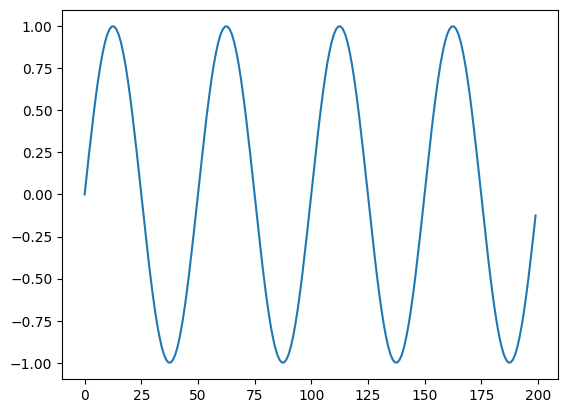

In [4]:
# Show the first 100 points
plt.plot(datapoints[:200])
plt.show()

We generate a Dataset and a Dataloader, which attempts to predict the value of a stock at time $ t + 1 $ given the value of the stock at time $ t $. 

In [5]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints):
        self.inputs_number = 1
        self.outputs_number = 1
        self.datapoints = datapoints
        self.inputs = [datapoints[i:i + self.inputs_number] for i in range(len(datapoints) - self.inputs_number)]
        self.outputs = [datapoints[i + self.outputs_number] for i in range(len(datapoints) - self.outputs_number)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs

In [6]:
# Create dataset and dataloader
dataset = CustomSeriesDataset(datapoints)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = False)

### A problem with this prediction

Our objective is to predict the value of a stock at time $ t + 1 $ given the value of the stock at time $ t $. It consists of a regression problem, with 1 input feature and 1 output feature. 

For instance, we could see the input and output at time $ t = 17 $.

In [8]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #17: ", inputs[17])
    print("Output for sample #17: ", outputs[17])
    break

Input for sample #17:  tensor([0.8440])
Output for sample #17:  tensor([0.7710])


There is a problem, however: we have multiple samples in the dataset that have the same input values, but two different output values (for instance, on the ascending or descending part of the sinusoid curve, as shown below).

In [7]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #0: ", inputs[0])
    print("Output for sample #0: ", outputs[0])
    print("Input for sample  #25: ", inputs[25])
    print("Output for sample  #25: ", outputs[25])
    break

Input for sample #0:  tensor([0.])
Output for sample #0:  tensor([0.1250])
Input for sample  #25:  tensor([0.])
Output for sample  #25:  tensor([-0.1250])


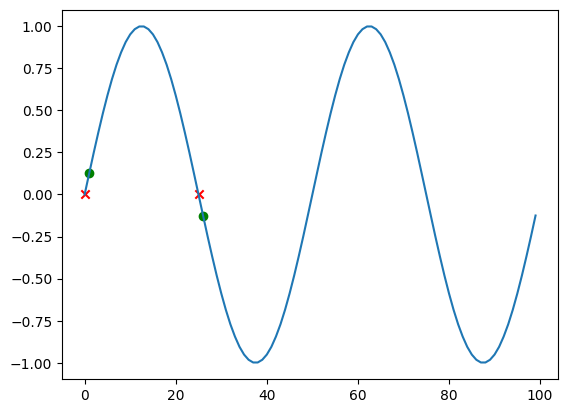

In [8]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.scatter(0, inputs[0], c = 'r', marker = 'x')
plt.scatter(1, outputs[0], c = 'g')
plt.scatter(25, inputs[25], c = 'r', marker = 'x')
plt.scatter(26, outputs[25], c = 'g')
plt.show()

For that reason, it might be difficult to predict the value of a stock at time $ t + 1 $ given ONLY the value of the stock at time $ t $. In practice, we would need more points, maybe at time $ t $, $ t -1 $, $ t - 2 $, etc.

For instance, we could change the inputs to consist of the last two values of the stock at times $ t $ and $ t - 1 $, as shown below. Our problem would then become regression problem, with 2 input features and 1 output feature. 

But that is not what we will do in this notebook.

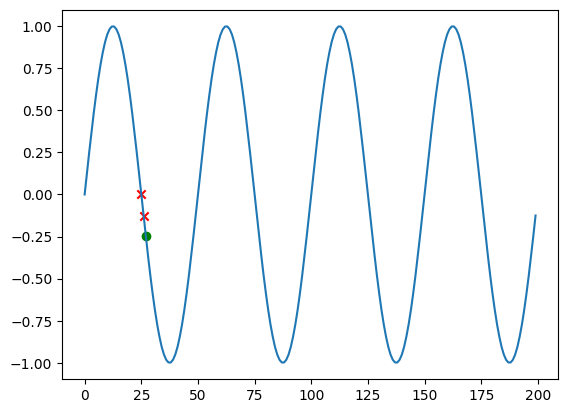

In [9]:
# Show the first 100 points
plt.plot(datapoints[:200])
plt.scatter(25, inputs[25], c = 'r', marker = 'x')
plt.scatter(26, inputs[26], c = 'r', marker = 'x')
plt.scatter(27, outputs[26], c = 'g')
plt.show()

### Using a DNN to predict the next point of the curve

Let us try to train a Deep Neural Network for this regression problem.

We will represent it as a succession of serveral linear layers, with ReLU activations, expecting one input feature and producing one output feature, as shown below.

In [10]:
class DNN(torch.nn.Module):
    
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(1, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 1))
        
    def forward(self, inputs):
        out = self.layers(inputs)
        return out

In [11]:
model = DNN().to(device)
print(model)

DNN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


### A simple trainer function

As before, we could write a simple trainer function, like so.

In [12]:
def train(model, dataloader, num_epochs, learning_rate):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [13]:
# Train the model
model = DNN().to(device)
train(model, dataloader, num_epochs = 20, learning_rate = 0.1)

Epoch 1/20, Loss: 0.0267
Epoch 2/20, Loss: 0.0160
Epoch 3/20, Loss: 0.0083
Epoch 4/20, Loss: 0.0081
Epoch 5/20, Loss: 0.0074
Epoch 6/20, Loss: 0.0075
Epoch 7/20, Loss: 0.0078
Epoch 8/20, Loss: 0.0076
Epoch 9/20, Loss: 0.0078
Epoch 10/20, Loss: 0.0083
Epoch 11/20, Loss: 0.0086
Epoch 12/20, Loss: 0.0088
Epoch 13/20, Loss: 0.0090
Epoch 14/20, Loss: 0.0092
Epoch 15/20, Loss: 0.0090
Epoch 16/20, Loss: 0.0089
Epoch 17/20, Loss: 0.0085
Epoch 18/20, Loss: 0.0082
Epoch 19/20, Loss: 0.0077
Epoch 20/20, Loss: 0.0076


### Test model predictions

The loss has decreased, and the model seems to have trained... But has it, really?

Let us check it by asking for predictions on the two problematic values we had identified earlier. We can see that the model tries its best, but it is simply not smart enough to predict two distinct values for each of these two data points.

In [14]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #0: ", inputs[0])
    print("Output for sample #0: ", outputs[0])
    print("Model prediction for sample #0:", model(torch.tensor([[inputs[0]], ]).to(device)))
    print("Input for sample  #25: ", inputs[25])
    print("Output for sample  #25: ", outputs[25])
    print("Model prediction for sample #0:", model(torch.tensor([[inputs[25]], ]).to(device)))
    break

Input for sample #0:  tensor([0.])
Output for sample #0:  tensor([0.1250])
Model prediction for sample #0: tensor([[0.0041]], device='cuda:0', grad_fn=<AddmmBackward0>)
Input for sample  #25:  tensor([0.])
Output for sample  #25:  tensor([-0.1250])
Model prediction for sample #0: tensor([[0.0041]], device='cuda:0', grad_fn=<AddmmBackward0>)


### What's next?

Obviously, this first DNN model is too simple, we will need something more sophisticated to deal with this time series dataset.

In the next notebook, we will change the inputs to consist of the last two values of the stock at times $ t $ and $ t - 1 $, as suggested earlier. Our problem will then become regression problem, with 2 input features and 1 output feature.

Will that be good enough to address the problem? We shall see.